## Link Prediction

### Importing Libraries

In [17]:
# importing required modules
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

### Reading Dataset

In [18]:
Dataset = pd.read_csv('../amazon_copurchase_5000.csv')
Dataset.columns = ['Source', 'Target']
# graph object construction
Graph = nx.from_pandas_edgelist(Dataset, 'Source', 'Target', create_using = nx.Graph())

### Create the Adjacency Matrix

In [19]:
# Get unique values from 'Source' and 'Target' columns and convert to sets
source = set(Dataset['Source'].unique())
target = set(Dataset['Target'].unique())

# Union of 'Source' and 'Target' sets to get all unique nodes
nodes = list(source.union(target))

# Calculate the number of nodes
number_of_nodes = len(nodes)

# Print the number of nodes
print(number_of_nodes)


1761


In [20]:

Adjacency_Matrix = nx.to_numpy_array(Graph, nodelist = nodes)
Adjacency_Matrix

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Identifying Missing Edges in a Graph Based on Shortest Paths

In [21]:
# Initialize an empty list to store missing nodes
missing_nodes = []
number = 0

# Loop through each node in the dataset
for i in tqdm(range(number_of_nodes)):
    # Loop through remaining nodes
    for j in range(number, number_of_nodes):
        if i != j:  # Exclude self-loops
            try:
                # Check if there exists a shortest path of length <= 2 between nodes i and j
                if nx.shortest_path_length(Graph, nodes[i], nodes[j]) <= 2:
                    # Check if there is no edge between nodes i and j in the adjacency matrix
                    if Adjacency_Matrix[i, j] == 0:
                        # Append the missing nodes to the list
                        missing_nodes.append([nodes[i], nodes[j]])
            except:
                continue
    number += 1

  0%|          | 1/1761 [00:00<20:11,  1.45it/s]

100%|██████████| 1761/1761 [03:10<00:00,  9.27it/s] 


### Removing Redundant Edges to Maintain Graph Connectivity

In [22]:
# Initialize a list to store removed edges
removed_edges = []
# Create a copy of the dataset
df = Dataset.copy()
# Initialize a counter
n = 0

# Iterate through each row index in the dataset
for i in tqdm(Dataset.index.values):
    # Create a graph excluding the current edge
    current_graph = nx.from_pandas_edgelist(df.drop(index=i), 'Source', 'Target', create_using=nx.Graph())
    
    # Check if the current graph has only one connected component and all nodes are present
    if nx.number_connected_components(current_graph) == 1 and len(current_graph.nodes) == number_of_nodes:
        n += 1
        if n >= 2:
            # Reset the counter after every two successful removals
            n = 0
            continue
        
        # If conditions are met, add the edge to the removed_edges list and update the DataFrame
        removed_edges.append(i)
        df = df.drop(index=i)


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [01:23<00:00, 60.18it/s]


### Generating Positive and Negative Samples for Graph Link Prediction

In [23]:
# Create DataFrame for positive samples
positive_samples = Dataset.loc[removed_edges].copy()
positive_samples['Label'] = 1

# Write positive samples to CSV
positive_samples.to_csv('Positive_Samples.csv')

# Create DataFrame for negative samples
negative_samples = pd.DataFrame(list(missing_nodes), columns=['Source', 'Target'])
negative_samples['Label'] = 0

# Limit negative samples to 5000 entries
negative_samples = negative_samples.head(5000)

# Write negative samples to CSV
negative_samples.to_csv('Negative_Samples.csv')


### Creating Training Dataset for Graph Link Prediction

In [24]:
# Concatenate positive and negative samples to create the training dataset
train_dataset = pd.concat([positive_samples, negative_samples], axis=0)

# Write the training dataset to CSV
train_dataset.to_csv('Train_Dataset.csv')

## Create graph object

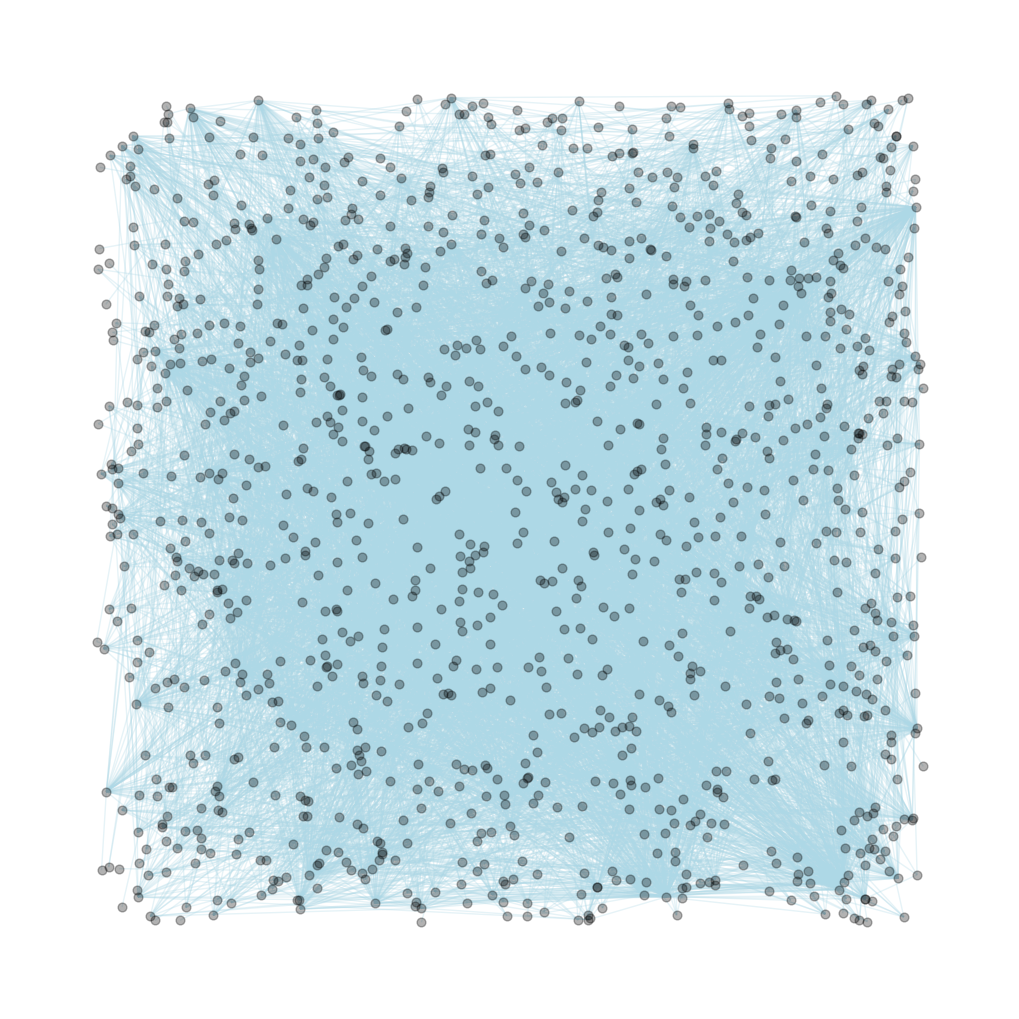

In [25]:
# Build graph from the training dataset
G_data = nx.from_pandas_edgelist(train_dataset, "Source", "Target", create_using=nx.Graph())

# Visualize the graph
plt.figure(figsize=(10, 10))
# Generate random layout for better visualization
pos = nx.random_layout(G_data, seed=30)
# Draw the graph
nx.draw(G_data, with_labels=False, pos=pos, node_size=40, alpha=0.3, edge_color="lightblue", node_color="black")
plt.show()

### Training Node2Vec Embeddings on Graph Data

In [26]:
import node2vec
from node2vec import Node2Vec

# Initialize Node2Vec object with parameters
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# Generate random walks
walks = node2vec.walks

# Train the Node2Vec model
n2v_model = node2vec.fit(window=7, min_count=1)


Generating walks (CPU: 1): 100%|██████████| 50/50 [00:15<00:00,  3.27it/s]


### Splitting Dataset into Training and Testing Sets

In [27]:
# Extract features (X) and labels (Y) from the train dataset
X_dataset = train_dataset[['Source', 'Target']]
Y_dataset = train_dataset['Label']

# Split the dataset into training and testing sets
# 70% for training, 30% for testing, with a fixed random state for reproducibility
X_train, X_test, Y_train, Y_test = train_test_split(X_dataset, Y_dataset, test_size=0.3, random_state=10)


### Logistic Regression Model Evaluation

In [28]:
# Title: Logistic Regression Model Evaluation
accuracies = []
roc_auc_scores =[]

# Import necessary libraries
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

# Instantiate Logistic Regression model with balanced class weights
lr = LogisticRegression(class_weight="balanced")

# Train the Logistic Regression model
lr.fit(X_train, Y_train)

# Make predictions on the test set
predictions_lr = lr.predict(X_test)

# Calculate and print accuracy score
accuracy_lr = accuracy_score(Y_test, predictions_lr)

print("Accuracy:", accuracy_lr)

# Calculate and print mean squared error
lr_mse = mean_squared_error(Y_test, predictions_lr)
print("Mean Squared Error:", lr_mse)

# Calculate and print ROC AUC score
lr_roc_auc = roc_auc_score(Y_test, predictions_lr)
print("ROC AUC Score:", lr_roc_auc)

# Print classification report
print("Classification Report:")
print(classification_report(Y_test, predictions_lr.round()))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(Y_test, predictions_lr.round()))

accuracies.append(accuracy_lr)
roc_auc_scores.append(lr_roc_auc)


Accuracy: 0.919588592800374
Mean Squared Error: 0.08041140719962599
ROC AUC Score: 0.9075262191414576
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1478
           1       0.87      0.88      0.87       661

    accuracy                           0.92      2139
   macro avg       0.90      0.91      0.91      2139
weighted avg       0.92      0.92      0.92      2139

Confusion Matrix:
[[1388   90]
 [  82  579]]


### Decision Tree Model Evaluation

In [29]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, classification_report, confusion_matrix

# Fit a Decision Tree model
dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train)

# Calculate and print accuracy score
accuracy_dt = dt.score(X_test, Y_test)
print("Accuracy:", accuracy_dt)

# Make predictions using the Decision Tree model
predictions_dt = dt.predict(X_test)

# Calculate and print mean squared error
mse_dt = mean_squared_error(Y_test, predictions_dt)
print("Mean Squared Error:", mse_dt)

# Calculate and print ROC AUC score
roc_auc_score_dt = roc_auc_score(Y_test, predictions_dt)
print("ROC AUC Score:", roc_auc_score_dt)

# Print classification report
print("Classification Report:")
print(classification_report(Y_test, predictions_dt))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(Y_test, predictions_dt))

accuracies.append(accuracy_dt)
roc_auc_scores.append(roc_auc_score_dt)


Accuracy: 0.9546517064048621
Mean Squared Error: 0.045348293595137916
ROC AUC Score: 0.9450242487394546
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1478
           1       0.93      0.92      0.93       661

    accuracy                           0.95      2139
   macro avg       0.95      0.95      0.95      2139
weighted avg       0.95      0.95      0.95      2139

Confusion Matrix:
[[1434   44]
 [  53  608]]


### Random Forest Model Evaluation

In [30]:
# Title: Random Forest Classifier Model Evaluation

# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, classification_report, confusion_matrix

# Instantiate Random Forest Classifier with balanced class weights and 100 estimators
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rf.fit(X_train, Y_train)

# Make predictions using Random Forest Classifier
predictions_rf = rf.predict(X_test)

# Calculate and print accuracy score
accuracy_rf = accuracy_score(Y_test, predictions_rf)
print("Accuracy:", accuracy_rf)

# Calculate and print ROC AUC score
roc_auc_score_rf = roc_auc_score(Y_test, predictions_rf)
print("ROC AUC Score:", roc_auc_score_rf)

# Calculate and print mean squared error
mse_rf = mean_squared_error(Y_test, predictions_rf)
print("Mean Squared Error:", mse_rf)

# Print classification report
print("Classification Report:")
print(classification_report(Y_test, predictions_rf.round()))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(Y_test, predictions_rf.round()))

accuracies.append(accuracy_rf)
roc_auc_scores.append(roc_auc_score_rf)



Accuracy: 0.9644693782141187
ROC AUC Score: 0.9487833663269045
Mean Squared Error: 0.035530621785881254
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1478
           1       0.98      0.91      0.94       661

    accuracy                           0.96      2139
   macro avg       0.97      0.95      0.96      2139
weighted avg       0.96      0.96      0.96      2139

Confusion Matrix:
[[1463   15]
 [  61  600]]


## Support Vector Machine

In [33]:
# Import necessary libraries
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Instantiate SVM model with linear kernel
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, Y_train)

# Make predictions using SVM model
predictions_svm = svm_model.predict(X_test)

# Calculate and print accuracy score
accuracy_svm = accuracy_score(Y_test, predictions_svm)
print("Accuracy:", accuracy_svm)

# Calculate and print ROC AUC score
roc_auc_svm = roc_auc_score(Y_test, predictions_svm)
print("ROC AUC Score:", roc_auc_svm)

# Calculate and print mean squared error
mse_svm = mean_squared_error(Y_test, predictions_svm)
print("Mean Squared Error:", mse_svm)

# Print classification report
print("Classification Report:")
print(classification_report(predictions_svm, Y_test))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(predictions_svm, Y_test))

accuracies.append(accuracy_svm)
roc_auc_scores.append(roc_auc_svm)



Accuracy: 0.9401589527816737
ROC AUC Score: 0.9073583511266605
Mean Squared Error: 0.059841047218326324
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1586
           1       0.82      0.98      0.89       553

    accuracy                           0.94      2139
   macro avg       0.91      0.95      0.93      2139
weighted avg       0.95      0.94      0.94      2139

Confusion Matrix:
[[1468  118]
 [  10  543]]


## Evaluate model performance

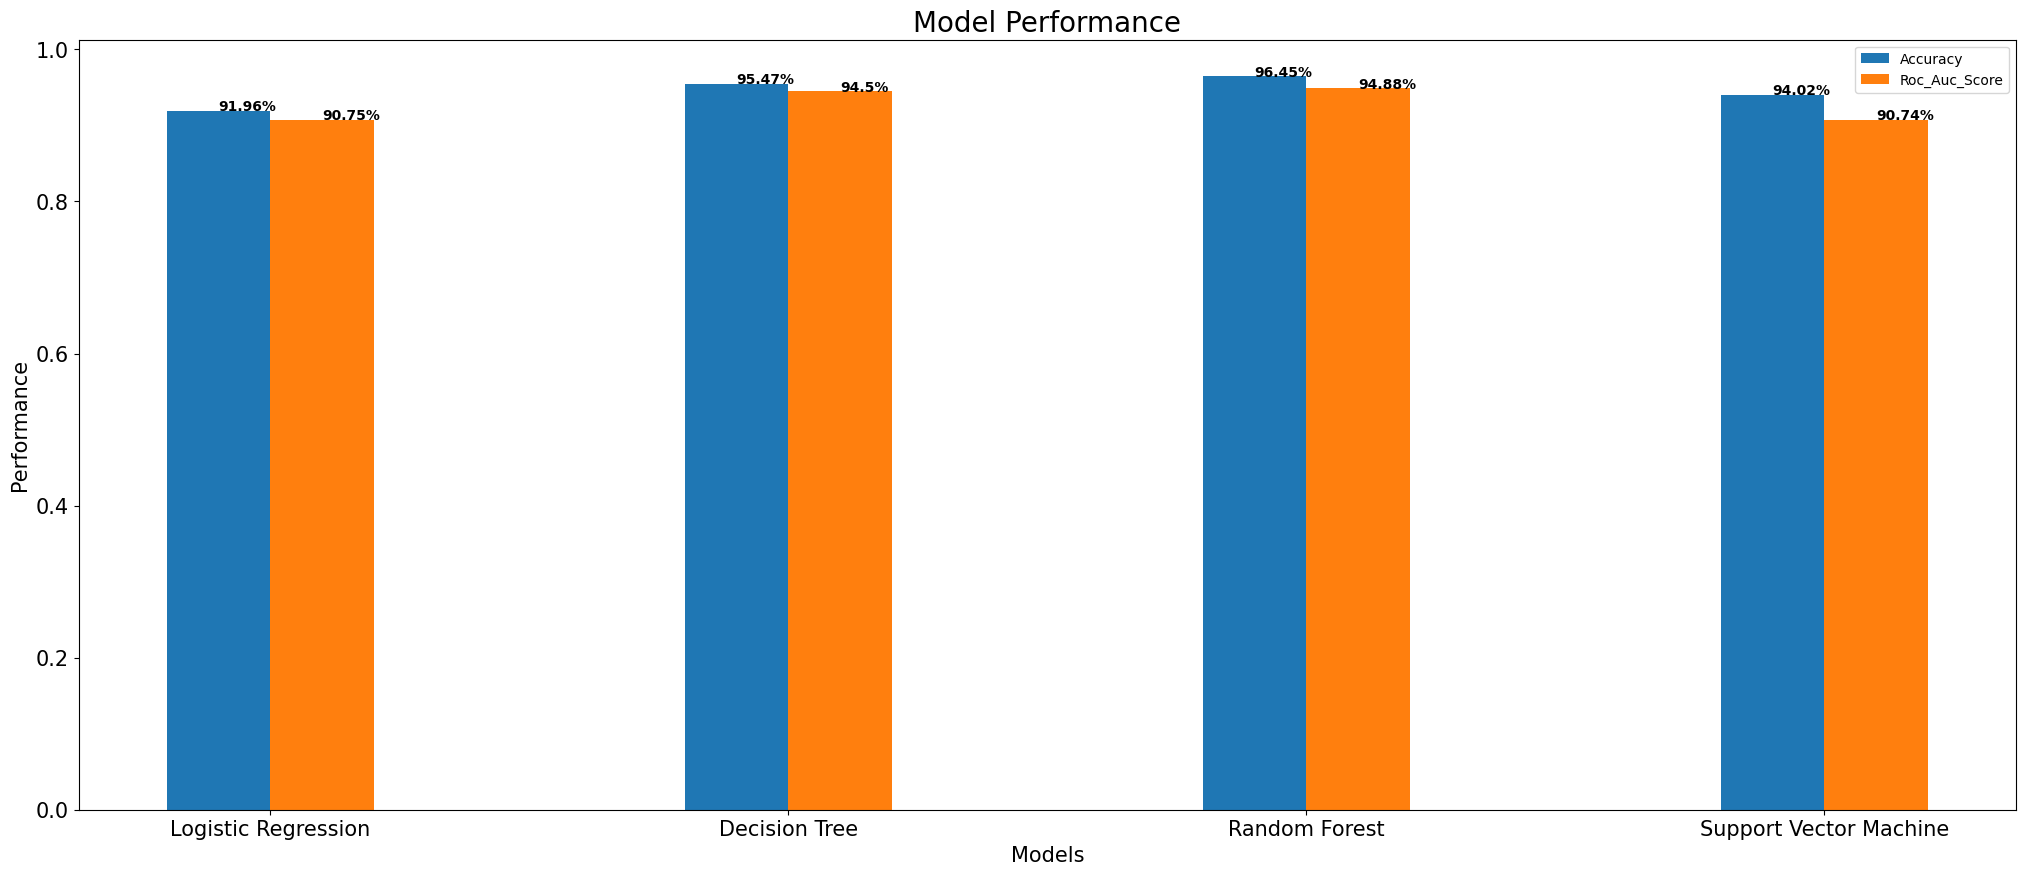

In [32]:

models =["Logistic Regression", "Decision Tree", "Random Forest", "Support Vector Machine"]
X_axis = np.arange(len(models))

plt.figure(figsize = (25,10))

plt.bar(X_axis - 0.1, accuracies, 0.2, label = 'Accuracy')
plt.bar(X_axis + 0.1, roc_auc_scores, 0.2, label = 'Roc_Auc_Score')

plt.xticks(X_axis, models, fontsize =15)
plt.yticks(fontsize =15)
plt.xlabel("Models", fontsize =15)
plt.ylabel("Performance", fontsize=15)
plt.title("Model Performance", fontsize = 20)
plt.legend()
for i in range(len(models)):
  plt.text(i-0.1, accuracies[i], str(round(accuracies[i]*100, 2))+'%', color='black', fontweight='bold')
  plt.text(i+0.1, roc_auc_scores[i], str(round(roc_auc_scores[i]*100, 2))+'%', color='black', fontweight='bold')
plt.show()
